In [1]:
import sys
sys.path.append('..')
from run import test
from dataset import get_dataloaders
from pathlib import Path
import tomllib
import os
import json
from datetime import datetime
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from model import UNet

In [2]:
CONFIG_PATH = Path.cwd().parent / "config.toml"
with open(CONFIG_PATH, "rb") as f:
    cfg = tomllib.load(f)

In [3]:
batch_size=20
in_channels = cfg["in_channels"]
out_channels = cfg["out_channels"]
model = UNet(
        in_channels=in_channels,
        out_channels=out_channels
    )

In [4]:
test_loader = get_dataloaders(split="test", batch_size=batch_size, num_workers=4)

Loading OxfordIIITPet dataset...
Stratified split - Train: 3271, Val: 409, Test: 368
Train: 3271 samples, 163 batches
Val:   409 samples, 21 batches
Test:  368 samples, 19 batches


In [5]:
device = "cuda"
checkpoint_path = "../checkpoints/new.pt"

model = model.to(device)

# Load checkpoint if provided
if checkpoint_path and os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    print("Checkpoint loaded successfully")

print(f"Testing on device: {device}")
print("-" * 60)

# Test
model.eval()
test_loss = 0.0
test_acc = 0.0
num_batches = 0

loss_fn = nn.CrossEntropyLoss()
test_pbar = tqdm(test_loader, desc="Testing", unit="batch")

with torch.no_grad():
    for x, y in test_pbar:
        x, y = x.to(device), (y.squeeze(1).long()-1).to(device)

        y_hat = model(x)
        loss = loss_fn(y_hat, y)

        acc = (torch.argmax(y_hat, dim=1) == y).float().mean().item()

        test_loss += loss.item()
        test_acc += acc
        num_batches += 1

        test_pbar.set_postfix(
            {
                "loss": f"{loss.item():.4f}",
                "acc": f"{acc:.4f}",
            }
        )

test_loss /= num_batches
test_acc /= num_batches

print(f"\n{'-' * 60}")
print(f"Test Results:")
print(f"  Loss:        {test_loss:.4f}")
print(f"  Accuracy:    {test_acc:.4f} ({test_acc*100:.2f}%)")
print("-" * 60)

results = {
    "test_loss": test_loss,
    "test_acc": test_acc,
}

# Save results to JSON
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"checkpoints/test_results_{timestamp}.json"
os.makedirs("checkpoints", exist_ok=True)
with open(filename, "w") as f:
    json.dump(results, f, indent=2)
print(f"Results saved to {filename}")


Testing on device: cuda
------------------------------------------------------------


Testing: 100%|██████████| 19/19 [00:06<00:00,  2.97batch/s, loss=1.1052, acc=0.1255]


------------------------------------------------------------
Test Results:
  Loss:        1.1039
  Accuracy:    0.1217 (12.17%)
------------------------------------------------------------
Results saved to checkpoints/test_results_2025-12-25_00-38-50.json


In [6]:
x.shape, y.shape, y_hat.shape

(torch.Size([8, 3, 572, 572]),
 torch.Size([8, 388, 388]),
 torch.Size([8, 3, 388, 388]))

In [7]:
idx = 0
img = x[idx]
y_true = y[idx]
y_pred = y_hat[idx]

In [8]:
img.shape,y_true.shape,y_pred.shape

(torch.Size([3, 572, 572]), torch.Size([388, 388]), torch.Size([3, 388, 388]))

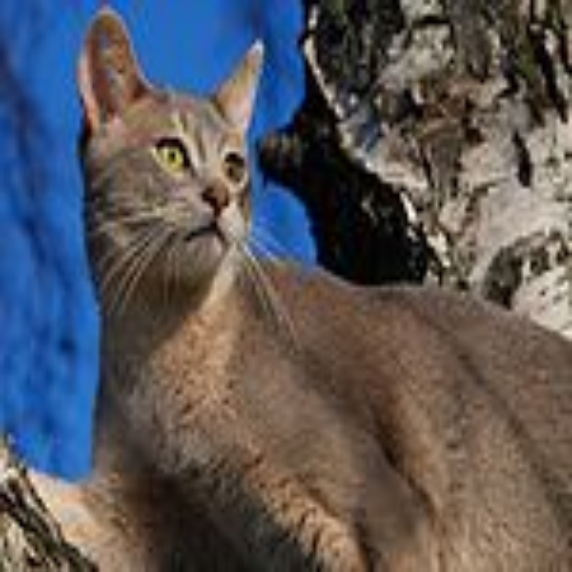

In [9]:
import torchvision.transforms.functional as F

# Denormalize the image
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(img.device)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(img.device)

img = img * std + mean  # reverse normalization
img = img.clamp(0, 1)    # ensure valid range

# Display
F.to_pil_image(img.cpu())


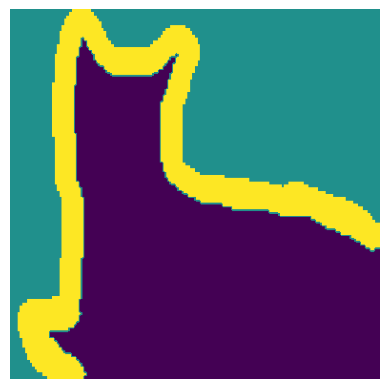

In [10]:
plt.imshow(y_true.cpu().squeeze(), cmap='viridis')
plt.axis('off')
plt.show()

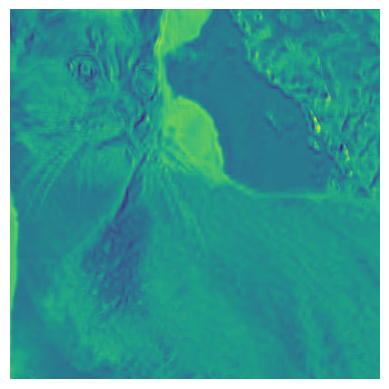

In [11]:
plt.imshow(y_pred[0].cpu(), cmap='viridis')
plt.axis('off')
plt.show()